<a href="https://colab.research.google.com/github/DMartinezT/msc_oxford_dissertation/blob/main/def_distributional_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prelims

In [ ]:
! pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 361 kB 5.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.metrics import pairwise_distances

import torch
import torch.nn as nn
from torch.optim import Adam

import gpytorch
from gpytorch.kernels import Kernel
from gpytorch.kernels import RBFKernel
from gpytorch.constraints import Positive

from google.colab import files

In [ ]:
def median_heuristic(x):
    """[One dimensional Median Heuristic]

    Args:
        x ([torch tensor]): [One dimensional torch tensor]

    Returns:
        [type]: [lengthscale obtained using median heuristic]
    """
    x_np = x.numpy()

    return np.median(pairwise_distances(x_np))

def postprocess_rbf(dist_mat):
    return dist_mat.div_(-2).exp_()

class RBFKernel_with_ND(Kernel):

    def __init__(self, eta=torch.tensor(1.), **kwargs):
        super(RBFKernel_with_ND, self).__init__(**kwargs)

        self.register_parameter(
            name="raw_eta", parameter=torch.nn.Parameter(eta)
        )
        eta_constraint = Positive()

        self.register_constraint("raw_eta", eta_constraint)

    has_lengthscale = True

    @property
    def eta(self):
        return self.raw_eta_constraint.transform(self.raw_eta)
    
    @eta.setter
    def eta(self, value):
        return self._set_eta(value)
    
    def _set_eta(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_eta)
        
        self.initialize(raw_eta=self.raw_eta_constraint.inverse_transform(value))
    

    def forward(self, x1, x2, nuc_dom=False, diag=False, **params):

        if nuc_dom:
            
            # 2 times the lengthscale to obtain the first exp component
            x1_ = x1.div(np.sqrt(2)*self.lengthscale)
            x2_ = x2.div(np.sqrt(2)*self.lengthscale)

            first_component = self.covar_dist(x1_, x2_, square_dist=True, diag=diag, dist_postprocess_func=postprocess_rbf, postprocess=True, **params)

            # computing the non-stationary component
            x1_p = x1.div(2)
            x2_p = x2.div(2)
            x1_2 = x1_p.div(torch.sqrt(0.5*self.lengthscale**2 + self.eta**2))
            x2_2 = -x2_p.div(torch.sqrt(0.5*self.lengthscale**2 + self.eta**2))

            second_component = self.covar_dist(x1_2, x2_2, square_dist=True, diag=diag, dist_postprocess_func=postprocess_rbf, postprocess=True, **params)

            # scaling factor
            D = len(self.lengthscale)
            scale = (2*np.pi)**(D/2)*torch.prod(2 / self.lengthscale + self.eta**(-2))**(-0.5)

            #return scale * first_component*second_component            
            return scale*first_component*second_component            

            
        else:
            x1_ = x1.div(self.lengthscale)
            x2_ = x2.div(self.lengthscale)
            return self.covar_dist(
                x1_, x2_, square_dist=True, diag=diag, dist_postprocess_func=postprocess_rbf, postprocess=True, **params
            )



# Distributional shift

In [ ]:
def true_counterfactual_mean_embedding(genx, gentestx, geny, testyten, optim_x_scle, optim_y_scle, optim_eta, optim_lambda, M = 1000):

  xten = genx(M)
  yten = geny(xten)
  testxten = gentestx(M)

  # Tensorize
  xten = torch.tensor(xten).float()
  yten = torch.tensor(yten).float()
  testxten = torch.tensor(testxten).float()
  testyten = torch.tensor(testyten).float()

  # Define kernels using the optimal params
  k = RBFKernel_with_ND(ard_num_dims=xten.shape[1])
  k.lengthscale = optim_x_scle

  l = RBFKernel_with_ND(ard_num_dims=yten.shape[1])
  l.lengthscale = optim_y_scle
  l.eta = optim_eta

  cme_reg = optim_lambda**2


  m = testxten.shape[0]
  ones_m = torch.ones([m,1])
  ones_over_m = ones_m / m

  aux = ones_over_m.T @ k(testxten, xten).evaluate() @ k(xten).add_diag(cme_reg).inv_matmul(l(yten, testyten).evaluate()) 
  return aux.detach().numpy().reshape(-1)

def frequentist_counterfactual_mean_embedding(xten, testxten, yten, testyten, optim_x_scle, optim_y_scle, optim_eta, optim_lambda):
  # Define kernels using the optimal params
  k = RBFKernel_with_ND(ard_num_dims=xten.shape[1])
  k.lengthscale = optim_x_scle

  l = RBFKernel_with_ND(ard_num_dims=yten.shape[1])
  l.lengthscale = optim_y_scle
  l.eta = optim_eta

  cme_reg = optim_lambda**2

  m = testxten.shape[0]
  ones_m = torch.ones([m,1])
  ones_over_m = ones_m / m

  aux = ones_over_m.T @ k(testxten, xten).evaluate() @ k(xten).add_diag(cme_reg).inv_matmul(l(yten, testyten).evaluate()) 
  return aux.detach().numpy().reshape(-1)

def posterior_mean_and_cov(xten, testxten, yten, testyten, optim_x_scle, optim_y_scle, optim_eta, optim_lambda, nuc_reg = 0):

  # Define kernels using the optimal params
  k = RBFKernel_with_ND(ard_num_dims=xten.shape[1])
  k.lengthscale = optim_x_scle

  l = RBFKernel_with_ND(ard_num_dims=yten.shape[1])
  l.lengthscale = optim_y_scle
  l.eta = optim_eta

  cme_reg = optim_lambda**2
  nuc_reg = torch.tensor(nuc_reg)

  m = testxten.shape[0]
  ones_m = torch.ones([m,1])
  ones_over_m = ones_m / m

  A = ones_over_m.T @ k(testxten, xten).evaluate() @ k(xten).add_diag(cme_reg).inv_matmul(l(yten).evaluate()) 
  B = l(yten, nuc_dom = True).add_diag(nuc_reg).inv_matmul(l(yten, testyten).evaluate())

  posterior_mean = A @ B

  C1 = ones_over_m.T @ k(testxten) @ ones_over_m 
  C = C1 * l(testyten, nuc_dom = True) 
  D = ones_over_m.T @ k(testxten, xten).evaluate() @ k(xten).add_diag(cme_reg).inv_matmul(k(xten, testxten).evaluate()) @ ones_over_m
  F = l(testyten, yten, nuc_dom = True) @ l(yten, nuc_dom = True).add_diag(nuc_reg).inv_matmul(l(yten, testyten).evaluate())
  posterior_cov = (C-D*F).evaluate()
  posterior_diag_cov = posterior_cov.diag()

  print("C1: ", C1, "D: ", D)

  return posterior_mean.detach().numpy().reshape(-1), posterior_diag_cov.detach().numpy().reshape(-1)

# 4 different shifts

In [ ]:
random_state = 0
np.random.seed(random_state)

# gen_y = lambda x: x*np.sin(x) +   0.0*np.random.normal(size=(x.shape[0], 1))
gen_y = lambda x: x*np.sin(np.pi*x) +   .2*np.random.normal(size=(x.shape[0], 1))
gen_y = lambda x: x*np.sin(np.pi*x) +   .5*np.random.normal(size=(x.shape[0], 1))

n = 500
loc = -3
scale = 3

x = np.random.normal(loc=loc, scale=scale, size=(n, 1))
x = np.random.uniform(low=loc, high=scale, size=(n, 1))

y = gen_y(x)

# Tensorise:
xten = torch.tensor(x).float()
yten = torch.tensor(y).float()

In [ ]:
ntest = 50

epsy = 10
epsy1 = epsy
epsx1 = 5

epsy2 = epsy
epsx2 = 7

epsy3 = epsy
epsx3 = 9

epsy4 = epsy
epsx4 = 11

# Define test sets
testx1 = x + epsx1
testy1 = np.linspace(np.min(y) - epsy1, np.max(y) + epsy1, ntest)

testx2 = x + epsx2
testy2 = np.linspace(np.min(y) - epsy2, np.max(y) + epsy2, ntest)

testx3 = x + epsx3
testy3 = np.linspace(np.min(y) - epsy3, np.max(y) + epsy3, ntest)

testx4 = x + epsx4
testy4 = np.linspace(np.min(y) - epsy4, np.max(y) + epsy4, ntest)

# Tensorize
testxten1 = torch.tensor(testx1).float()
testyten1 = torch.tensor(testy1).float()

testxten2 = torch.tensor(testx2).float()
testyten2 = torch.tensor(testy2).float()

testxten3 = torch.tensor(testx3).float()
testyten3 = torch.tensor(testy3).float()

testxten4 = torch.tensor(testx4).float()
testyten4 = torch.tensor(testy4).float()

optim_x_scle = torch.tensor(2.)
optim_y_scle = torch.tensor(2.)
optim_eta = torch.tensor(2.)
optim_lambda = torch.tensor(.1)


posterior_mean_np_1, posterior_diag_cov_np_1 = posterior_mean_and_cov(xten, testxten1, yten, testyten1, optim_x_scle, optim_y_scle, optim_eta, optim_lambda)
posterior_mean_np_2, posterior_diag_cov_np_2 = posterior_mean_and_cov(xten, testxten2, yten, testyten2, optim_x_scle, optim_y_scle, optim_eta, optim_lambda)
posterior_mean_np_3, posterior_diag_cov_np_3 = posterior_mean_and_cov(xten, testxten3, yten, testyten3, optim_x_scle, optim_y_scle, optim_eta, optim_lambda)
posterior_mean_np_4, posterior_diag_cov_np_4 = posterior_mean_and_cov(xten, testxten4, yten, testyten4, optim_x_scle, optim_y_scle, optim_eta, optim_lambda)

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  NumericalWarning,
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  NumericalWarning,
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  NumericalWarning,


C1:  tensor([[0.6076]], grad_fn=<MmBackward0>) D:  tensor([[0.4267]], grad_fn=<MmBackward0>)
C1:  tensor([[0.6076]], grad_fn=<MmBackward0>) D:  tensor([[0.1760]], grad_fn=<MmBackward0>)
C1:  tensor([[0.6076]], grad_fn=<MmBackward0>) D:  tensor([[0.0207]], grad_fn=<MmBackward0>)
C1:  tensor([[0.6076]], grad_fn=<MmBackward0>) D:  tensor([[0.0004]], grad_fn=<MmBackward0>)


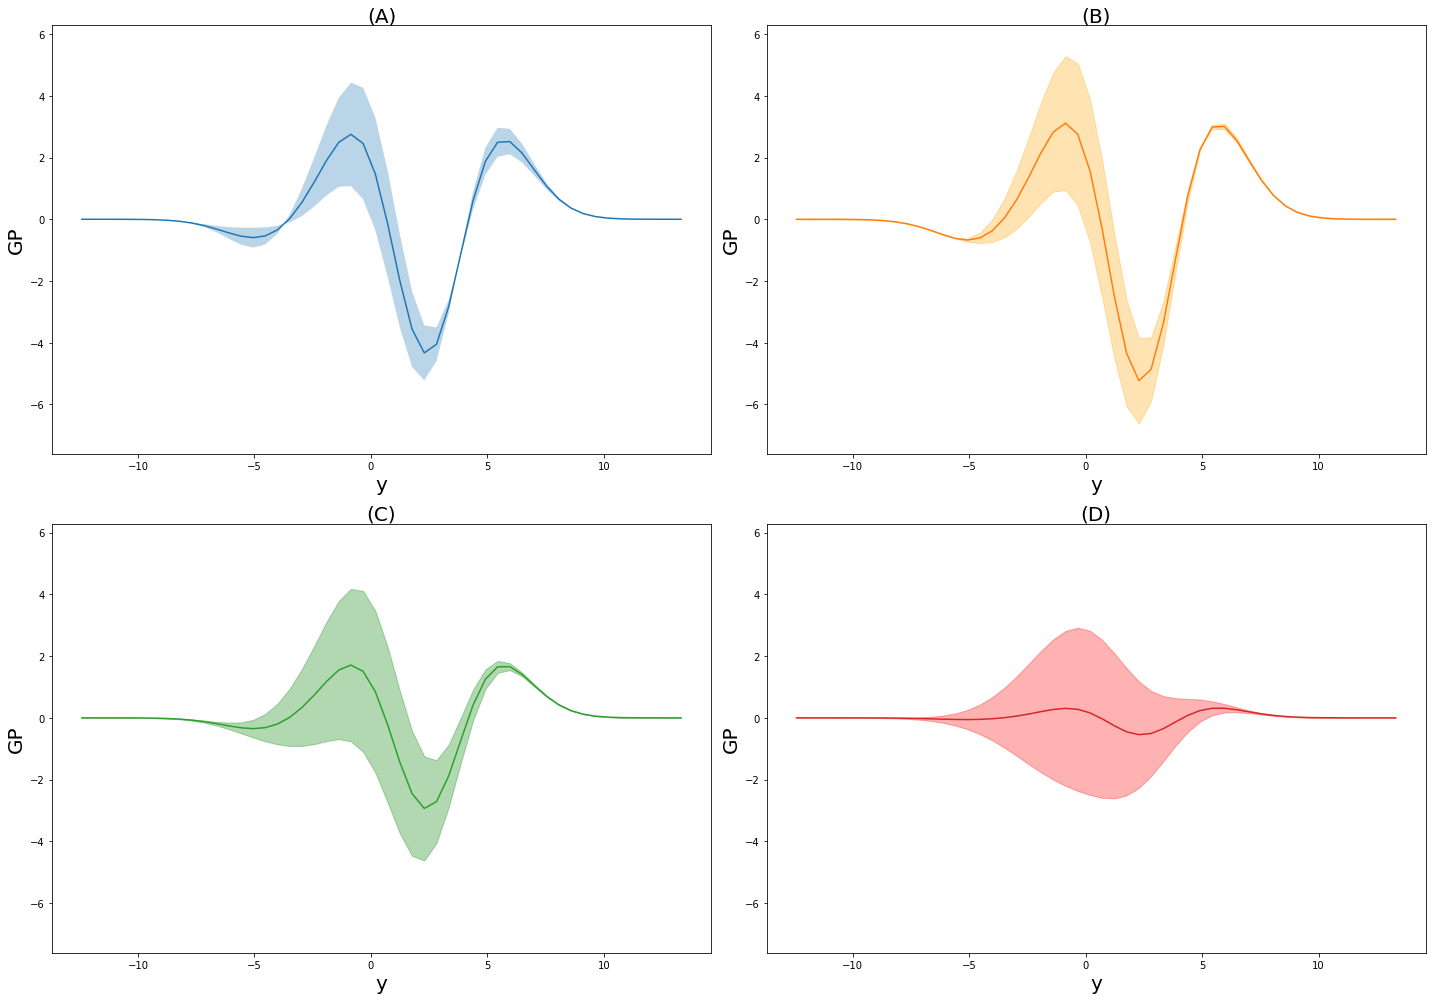

In [ ]:
plt.rcParams["figure.figsize"] = (20,14)
plt.rcParams['axes.titlepad'] = -40  # pad is in points...

fig, axs = plt.subplots(2, 2)
# Defining custom 'xlim' and 'ylim' values.
mgp = np.array([posterior_mean_np_1 + 1.96*posterior_diag_cov_np_1, posterior_mean_np_2 + 1.96*posterior_diag_cov_np_2,
              posterior_mean_np_3 + 1.96*posterior_diag_cov_np_3, posterior_mean_np_4 + 1.96*posterior_diag_cov_np_4])
mmgp = np.array([posterior_mean_np_1 - 1.96*posterior_diag_cov_np_1, posterior_mean_np_2 - 1.96*posterior_diag_cov_np_2,
              posterior_mean_np_3 - 1.96*posterior_diag_cov_np_3, posterior_mean_np_4 - 1.96*posterior_diag_cov_np_4])


custom_gplim = (np.min(mmgp) - 1, np.max(mgp) + 1)
custom_ylim = (np.min(y), np.max(y))
# Setting the values for all axes.
plt.setp(axs, ylim=custom_gplim)

fontsize = 20

axs[0, 0].plot(testy1, posterior_mean_np_1)
axs[0, 0].fill_between(testy1, posterior_mean_np_1 + 1.96*posterior_diag_cov_np_1, posterior_mean_np_1 - 1.96*posterior_diag_cov_np_1, alpha=0.3)
title = 'Shift: ' + str(epsx1)
title = '(A)'
axs[0, 0].set_title(title, fontsize = fontsize)

axs[0, 1].plot(testy2, posterior_mean_np_2, 'tab:orange')
axs[0, 1].fill_between(testy2, posterior_mean_np_2 + 1.96*posterior_diag_cov_np_2, posterior_mean_np_2 - 1.96*posterior_diag_cov_np_2, alpha=0.3, color = 'orange')
title = 'Shift: ' + str(epsx2)
title = '(B)'
axs[0, 1].set_title(title, fontsize = fontsize)

axs[1, 0].plot(testy3, posterior_mean_np_3, 'tab:green')
axs[1, 0].fill_between(testy3, posterior_mean_np_3 + 1.96*posterior_diag_cov_np_3, posterior_mean_np_3 - 1.96*posterior_diag_cov_np_3, alpha=0.3, color = 'green')
title = 'Shift: ' + str(epsx3)
title = '(C)'
axs[1, 0].set_title(title, fontsize = fontsize)

axs[1, 1].plot(testy4, posterior_mean_np_4, 'tab:red')
axs[1, 1].fill_between(testy4, posterior_mean_np_4 + 1.96*posterior_diag_cov_np_4, posterior_mean_np_4 - 1.96*posterior_diag_cov_np_4, alpha=0.3, color = 'red')
title = 'Shift: ' + str(epsx4)
title = '(D)'
axs[1, 1].set_title(title, fontsize = fontsize)

for ax in axs.flat:
    ax.set_xlabel('y', fontsize=20)
    ax.set_ylabel('GP', fontsize=20)

plt.tight_layout()


In [ ]:
fig.savefig("shift.png", bbox_inches='tight')
files.download("shift.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# True mean embedding

In [ ]:
random_state = 0
np.random.seed(random_state)

gen_y = lambda x: x*np.sin(np.pi*x) +   1*np.random.normal(size=(x.shape[0], 1))
#gen_y = lambda x: x*np.sin(x) +   1.*np.random.normal(size=(x.shape[0], 1))
gen_y = lambda x: x*np.sin(x) +   .0*np.random.normal(size=(x.shape[0], 1))
gen_x_true = lambda n: np.random.normal(loc=0, scale=10, size=(n, 1))
gen_x_true = lambda n: np.random.uniform(low=-3, high=3, size=(n, 1))



n = 100
x = gen_x_true(n)
y = gen_y(x)

# Tensorise:
xten = torch.tensor(x).float()
yten = torch.tensor(y).float()


lambda_init = torch.tensor(0.3).float()
eta_init = torch.tensor(0.3).float()
y_lscale = 1.
eta_lscale = 1.
epoch = 300
lr = 1e-1
verbose = False


optim_x_scle = torch.tensor(2.)
optim_y_scle = torch.tensor(2.)
optim_eta = torch.tensor(2.)
optim_lambda = torch.tensor(.1)




In [ ]:
ntest = 100
nytest = 1000

gen_x_test = lambda n: np.random.normal(loc=0, scale=5, size=(n, 1))


#testx1 = gen_x_test(ntest)
testx1 = x+1
offset = 10
testy1 = np.linspace(np.min(y)-offset, np.max(y)+offset, nytest)

testxten1 = torch.tensor(testx1).float()
testyten1 = torch.tensor(testy1).float()

posterior_mean_np_1, posterior_diag_cov_np_1 = posterior_mean_and_cov(xten, testxten1, yten, testyten1, optim_x_scle, optim_y_scle, optim_eta, optim_lambda)
frequentist_estimator_1 = frequentist_counterfactual_mean_embedding(xten, testxten1, yten, testyten1, optim_x_scle, optim_y_scle, optim_eta, optim_lambda)
true_embedding = true_counterfactual_mean_embedding(gen_x_true, gen_x_test, gen_y, testyten1, optim_x_scle, optim_y_scle, optim_eta, optim_lambda, M = 10000)


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  NumericalWarning,
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  NumericalWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


C1:  tensor([[0.6147]], grad_fn=<MmBackward0>) D:  tensor([[0.6142]], grad_fn=<MmBackward0>)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

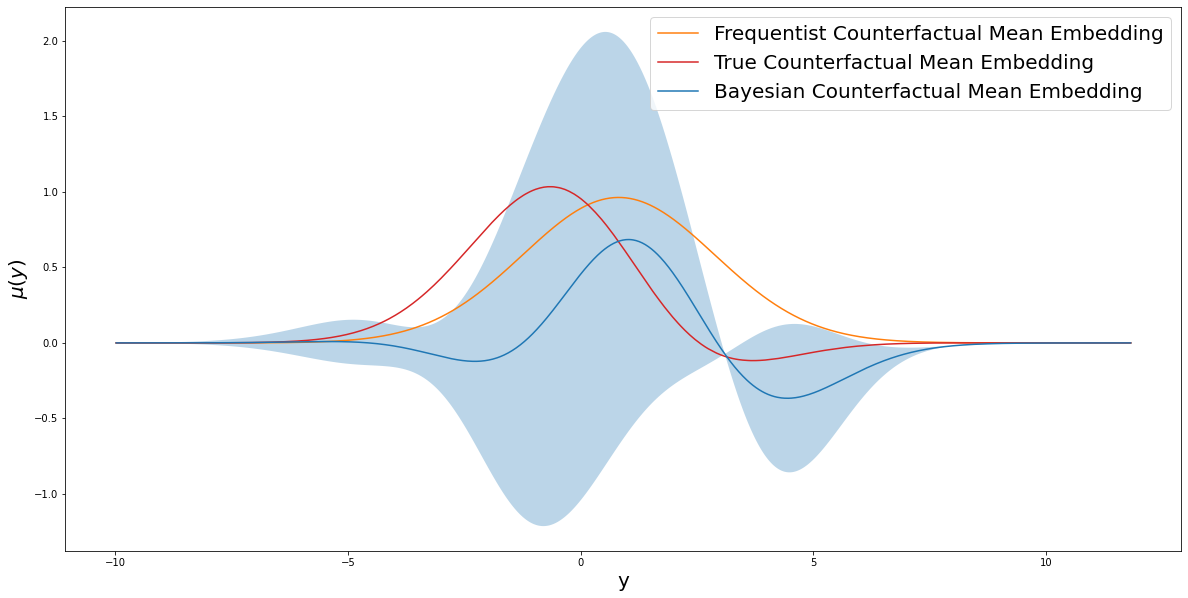

In [ ]:
  
fontsize = 16
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(testy1, frequentist_estimator_1, 'tab:orange', label='Frequentist Counterfactual Mean Embedding')
plt.plot(testy1, true_embedding, 'tab:red', label='True Counterfactual Mean Embedding')
plt.plot(testy1, posterior_mean_np_1, label = 'Bayesian Counterfactual Mean Embedding')
plt.fill_between(testy1, posterior_mean_np_1 + 1.96*posterior_diag_cov_np_1, posterior_mean_np_1 - 1.96*posterior_diag_cov_np_1, alpha=0.3)
plt.xlabel('y', fontsize=20)
plt.ylabel(r'$\mu(y)$', fontsize = 20)
plt.legend(prop={'size': 20})

plt.savefig("true_embedding.png", bbox_inches='tight')
files.download("true_embedding.png") 

# $\mathbb{E}[f(X)] \neq f(\mathbb{E}[X])$

In [ ]:
def rv(alpha, n):
  return 1.*alpha + np.random.normal(loc = 0, scale = 1 - alpha, size = n)
def f(x):
  return x**2

num = 1000
n = 500000
alpha_range = np.linspace(start = 0, stop = .5, num = num)
ef = np.zeros(num)
fe = np.zeros(num)
for i, alpha in enumerate(alpha_range):
  X = rv(alpha, n)
  ef[i] = np.mean(f(X))
  fe[i] = f(np.mean(X))



In [ ]:
def rv1(alpha, n):
  res = np.zeros(n)
  for i in range(n):
    decider = np.random.normal(loc = 0, scale = 1)
    aux = np.random.normal(loc = alpha, scale = .0)
    if decider > 0:
      aux = -aux
    res[i] = aux
  return res

def f1(x):
  return np.cos(np.pi*x / 2)

num1 = 50
n1 = 100000
alpha_range1 = np.linspace(start = 0, stop = 1, num = num1)
ef1 = np.zeros(num1)
fe1 = np.zeros(num1)
for i, alpha in enumerate(alpha_range1):
  X = rv1(alpha, n1)
  ef1[i] = np.mean(f1(X))
  fe1[i] = f1(np.mean(X))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

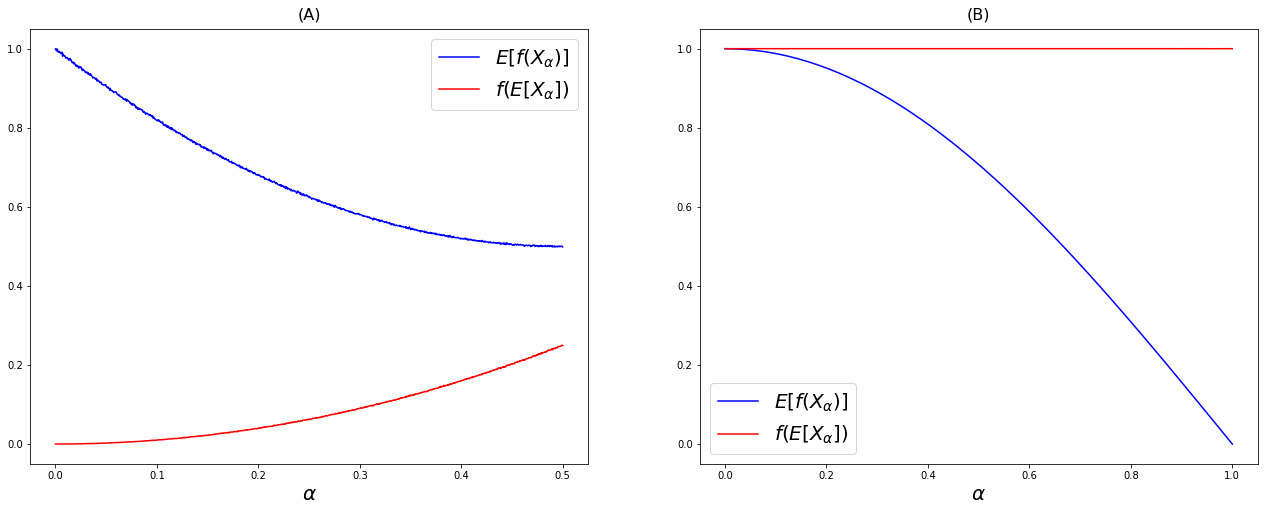

In [ ]:
plt.rcParams["figure.figsize"] = (22,8)
plt.rcParams['axes.titlepad'] = 10  # pad is in points...
fig, axs = plt.subplots(1, 2)
fontsize = 16

axs[0].plot(alpha_range, ef, color = "blue", label = r'$E[f(X_\alpha)]$')
axs[0].plot(alpha_range, fe, color = "red", label = r'$f(E[X_\alpha])$')
title = '(A)'
axs[0].set_title(title, fontsize = fontsize)
axs[0].legend(prop={'size': 20})

axs[1].plot(alpha_range1, ef1, color = "blue", label = r'$E[f(X_\alpha)]$')
axs[1].plot(alpha_range1, fe1, color = "red", label = r'$f(E[X_\alpha])$')
title = '(B)'
axs[1].set_title(title, fontsize = fontsize)
axs[1].legend(prop={'size': 20})

for ax in axs.flat:
    ax.set_xlabel(r'$\alpha$', fontsize=20)

plt.savefig("effe.png", bbox_inches='tight')
files.download("effe.png") 
